# Empirical Review of Models for Predicting Financial Market Crashes Using Market Data
## COMP 451: Final Project - Code, experiments and plots
---


Written by
- Adrien Bélanger  
- Inigo Torres  
- Ping-Chieh Tu  

---


## Data and Imports

### Imports

In [1]:
import numpy as np
import yfinance as yf # to get our data

from sklearn.preprocessing import MinMaxScaler # to normalize our classes
from sklearn.model_selection import train_test_split # from tutorial code
from sklearn.metrics import accuracy_score, confusion_matrix # needed for plotting

from tensorflow.keras.models import Sequential, Model # sequential model for RNN
from tensorflow.keras.layers import (Input, Dense, Dropout, LayerNormalization,
                                     MultiHeadAttention, Flatten, Add, LSTM) # layers dense and long short term memory for RNN

import matplotlib.pyplot as plt # for plotting

from tensorflow.keras.optimizers import Adam
import tensorflow as tf

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

### Data

In [3]:
dfs = {} # Store all the data for our tickers, even though for now its just SP500
tickers = ['^GSPC',] # Ticker (identifier) for the SP500, which is arguably the most influential, we start with just this

# Got this code from https://www.kaggle.com/code/xxxxyyyy80008/predict-stock-market-crashes 
for ticker in tickers:
    cur_data = yf.Ticker(ticker)
    hist = cur_data.history(period="max")
    print(ticker, cur_data.info['shortName'], ticker, hist.shape, hist.index.min(), hist.index.max())
    dfs[ticker] = hist

# Preprocessign Functions:
# Calculates how much the price has gone down from its highest point, labeling those with a 0.005 quantile as crashes as per directive 1
# NOTE: got help from chatgpt for this function to find .pct_change, .cummax and .quantile
def calculate_drawdown_and_label(data, quantile_threshold=0.005):

    data['daily_return'] = data['Close'].pct_change()

    data['drawdown'] = data['Close'] / data['Close'].cummax() - 1

    crash_threshold = data['drawdown'].quantile(quantile_threshold)

    data['crash_label'] = (data['drawdown'] < crash_threshold).astype(int)

    return data

## Make the data we targetted the target (nice), we try to predict the market crashes 3 days in advance so shift_days = 3
def prepare_target(data, shift_days=3):
    data['target'] = (data['crash_label']).astype(int).shift(-shift_days) # complicated line that basically takes our data with crash label, turns the bools into an int, then shift the values by 3 days to predict in advance, since we want to predict 3 days in advance
    return data


# Database done
# Prepare data
def preprocess_data(data, sequence_length=15): # data is our data we

    scaler = MinMaxScaler(feature_range=(0, 1))  # Normalize our features between 0 and 1 to make sure its all the same, since prices and dropdown are very much not all on scale.
    scaled_data = scaler.fit_transform(data[['Close', 'daily_return', 'drawdown']].dropna()) # our simple features we defined before + the ones from hist, scale them and create. .dropna removes the rows that have features which are nan i.e. rows with missing features

    X = []
    y = []

    for i in range(len(scaled_data) - sequence_length): # process data by sequences of days to learn. This is a window, so we go from one day to the next. for example, if we have day 1 to day 15 on iteration i, at iteration i + 1 we have day 2 to 16. this window is a single datapoint within a single minibatch.
        days = scaled_data[i:i+sequence_length] # get the sequence of 15 days
        X.append(days) # add to x the data as sequences of 15 days
        y.append(data['target'].iloc[i + sequence_length]) # this is the target. It adds the value of the next sequence as the target, so we can predict future crashes

    X = np.array(X) # turn into array for processing
    y = np.array(y)
     
    
    y = y[~np.isnan(y)]  # remove nan of the last few data points, since we shift by 3 days the last few points. i.e. for day 1, the target is day 4 for three days. so at the end of the seuquence wed get 3 empty datapoints. 
    X = X[:len(y)]  # cut those data points which had no y, i.e. the last few days
    return X, y, scaler # return the scaler function to make sure when we process the test data and validation data, we can process the data before feeding it into our model



^GSPC S&P 500 ^GSPC (24351, 7) 1927-12-30 00:00:00-05:00 2024-12-06 00:00:00-05:00


## Models

### RNN

In [4]:
# RNN model from keras.
# NOTE: chtgpt helped me find the return_sequences parameter and input_shape parameters. it also helped me find the model.compile names of the specific functions (is it binary_cross_entropy or binary_crossentropy)
def rnn_model(input): # by giv
    model = Sequential() # choose the RNN (i.e. sequential) so we can stack models
    model.add(LSTM(units=50, return_sequences=True, input_shape=input)) # first lstm layer with 50 nodes (arbitrary), we return sequences not the final output since were passing it to another lstm layer
    model.add(LSTM(units=50)) # second LSTM layer, this time we do return the final output
    model.add(Dense(units=1, activation='sigmoid'))  #dense layer with 1 node to classify binary. because were classifying binarily whether theres a crash, then we use sigmoid to just classify if thres a crash or not
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # compile our model with an adam optimizer to adjust our learning rate when were getting closer.. might need to try sgd. binary cross entropy since were binary. accuracy to track during trainign and testing.
    return model

### Transformers

In [5]:
def positional_encoding(sequence_length, d_model):
    position = np.arange(sequence_length)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
    pe = np.zeros((sequence_length, d_model))
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    pe = pe[np.newaxis, ...]
    return tf.cast(pe, dtype=tf.float32)

def transformer_model(input_shape, num_heads=2, embed_dim=32, ff_dim=64):
    inputs = Input(shape=input_shape)
    x = inputs

    x = Dense(embed_dim)(x)

    sequence_length = input_shape[0]
    positional_encoding_layer = positional_encoding(sequence_length, embed_dim)
    x = x + positional_encoding_layer

    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim // num_heads)(x, x)
    attention_output = Add()([attention_output, x])
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)

    ffn_output = Dense(ff_dim, activation='relu')(attention_output)
    ffn_output = Dense(embed_dim)(ffn_output)
    ffn_output = Add()([ffn_output, attention_output])
    ffn_output = LayerNormalization(epsilon=1e-6)(ffn_output)

    flatten = Flatten()(ffn_output)
    outputs = Dense(1, activation='sigmoid')(flatten)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

### ARIMA

In [6]:
def forecast_arima(X_test, sequence_length, shift_days, threshold=0.005, p=5, d=1, q=0):
    predictions = []

    for i in range(len(X_test)):
       # make sure we ge tonly the sequence length
        if i + sequence_length > len(X_test):
            break  
        
        train_sequence = X_test[i, :, 0]  

        model = ARIMA(train_sequence, order=(p, q, d))  
        model_fit = model.fit()

        # clauclate the forecast on the next 3 days
        forecast = model_fit.forecast(steps=shift_days)

        # check the drawdown: NOTE: Got help
        forecast_drawdown = (np.array(forecast) / max(train_sequence) - 1)
        isit_crash = False
        for dd in forecast_drawdown: # check if anything is lower than the threshold
            if (dd < -threshold):
                isit_crash = True
                break
        
        predictions.append(1 if isit_crash == 1 else 0) # make it a crash if its 0

    return predictions

#### ARIMA - Stationarity test

In [7]:
from statsmodels.tsa.stattools import adfuller

df = dfs['^GSPC']

adf_test = adfuller(df['Close'])
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('ADF p-value: %f' % adf_test[1])

from statsmodels.tsa.stattools import kpss
kpss_result = kpss(df['Close'])
print(f'KPSS result: {kpss_result[1]}')

ADF Statistic: 7.406940
ADF p-value: 1.000000
KPSS result: 0.01


/var/folders/qn/vrv88lcd66jdmpx64t33xst80000gn/T/ipykernel_99703/2001048645.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(df['Close'])


From the ADF test and KPSS test result, our data is non-stationary, therefore the difference term $d$ is needed.

#### ARIMA - PACF and ACF

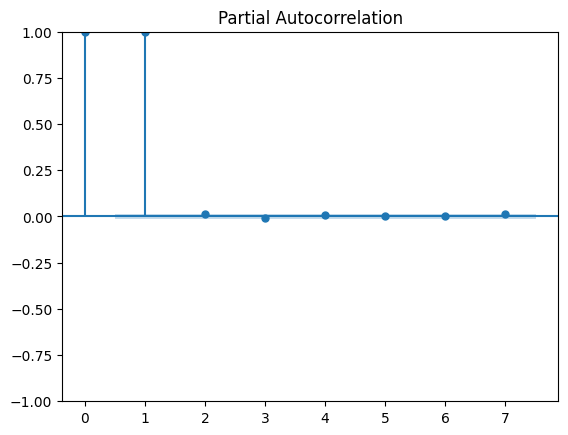

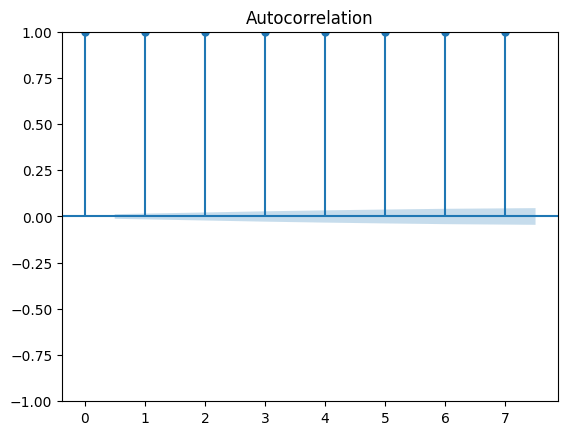

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
df = dfs['^GSPC']
plot_pacf(df['Close'], lags=7)
plot_acf(df['Close'], lags=7)
plt.show()

From PACF, we can choose either $p = 0$ or $p=1$. From ACF, it is hard to tell what should be the degree of $q$, so we will do grid search before each experiment do ensure that we do get the best result.

# Experiment 1

**Conditions:**

- Sliding window: 30 days

- Shift days: 14 days

## Hyperparameters and Preprocessing

### Hyperparameters

In [ ]:
SEQUENCE_LENGTH = 30 # how large our window is
TEST_SIZE = 0.2
EPOCHS = 20
BATCH_SIZE = 20
SHIFT_DAYS = 14 # how far ahead we want to predict market crashes

### Preprocessing

In [ ]:
# prep the data
for ticker, data in dfs.items():
    data = calculate_drawdown_and_label(data) # get the drawdown for our data
    data = prepare_target(data, SHIFT_DAYS)
    dfs[ticker] = data

# now we process our data, here we do as if we had multiple tickers, in case we add more later
sequence_length = SEQUENCE_LENGTH # hyperparameter for the length of the window. 15 is completely arbirtrary here, need to adjust to get better or worst results.
X = {} # data of all the tickers
y = {} # labels of all the tickers
scalers = {} # scalers of all the tickers
for ticker, data in dfs.items(): #iterate through each ticker, datapoint and the dataframes (dfs) we got from yf, and preprocess them then add them to the dictionnary
    X[ticker], y[ticker], scalers[ticker] = preprocess_data(data, sequence_length=sequence_length) 

# Combine data from all our tickers, joining them on axis 0 i.e. we want to concatenate all the rows together
X_all = np.concatenate([X[ticker] for ticker in X], axis=0)
y_all = np.concatenate([y[ticker] for ticker in y], axis=0) # same thing for labels

# give 20% as test size, 80% for our training data. this functino was found in the tutorial ipynb
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=TEST_SIZE, random_state=42)
# NOTE: chatgpt helped me for the input_shape
input_shape = (X_train.shape[1], X_train.shape[2]) # recall X_train is (batch_size, sequence_length, 3 (for 3 features for now)), here we give the batch size and the sequence length

## Training

### RNN

In [ ]:
exp_1_rnn_trained_model = rnn_model(input_shape) # build our model with our function from before

exp_1_rnn_trained_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test)) # train our model. relatively large batch size considering we dont have much data, but im getting pretty good accuracy. we use our test data for validation, arguably not great but were not using for early stopping so I guess its ok

##### GET ACCURACY AND CONFUSION MATRIX #####
exp_1_rnn_predictions_as_probabilities = exp_1_rnn_trained_model.predict(X_test)
exp_1_rnn_predictions_as_classes = (exp_1_rnn_predictions_as_probabilities > 0.5).astype(int) # make our predictions binary, a simple scaler that puts values higher than 0.5 to 1 and lower 0. astypeint to return 0 and 1 instead of true false array.
exp_1_rnn_accuracy = accuracy_score(y_test, exp_1_rnn_predictions_as_classes) # calculate our accuracy

exp_1_rnn_confusion_matrix_var = confusion_matrix(y_test, exp_1_rnn_predictions_as_classes) # plot the confusion matrix
#############################################


### FINAL ACCURACY
print(f"Test Accuracy: {exp_1_rnn_accuracy}") # print our final accuracy

### Transformers

In [ ]:
exp_1_transformer_trained_model = transformer_model(input_shape)
exp_1_transformer_trained_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

exp_1_transformer_predictions_as_probabilities = exp_1_transformer_trained_model.predict(X_test)
exp_1_transformer_predictions_as_classes = (exp_1_transformer_predictions_as_probabilities > 0.5).astype(int)

exp_1_transformer_accuracy = accuracy_score(y_test, exp_1_transformer_predictions_as_classes)
exp_1_transformer_confusion_matrix_var = confusion_matrix(y_test, exp_1_transformer_predictions_as_classes)

print(f"Transformers EXP 1 Accuracy: {exp_1_transformer_accuracy}")

NameError: name 'input_shape' is not defined

### ARIMA

In [ ]:
###### Grid Search

p, d, q = 0, 1, 0
best_hyperparameter = (0, 1, 0)
best_accuracy = 0

try: 
    for p in range(3): 
        for d in range(1, 3):  
            for q in range(6):  
                try:
                    print(f'Hyperparameter: p={p}, d={d}, q={q}')
                    exp_1_predictions = forecast_arima(
                        X_test, sequence_length=SEQUENCE_LENGTH, shift_days=SHIFT_DAYS, p=p, d=d, q=q
                    )
                    exp_1_predictions_as_classes = np.array(exp_1_predictions[:len(y_test)])
                    accuracy = accuracy_score(y_test[:len(exp_1_predictions_as_classes)], exp_1_predictions_as_classes)
                    print(f'Accuracy: {accuracy}')
                    
                    
                    if accuracy > best_accuracy:
                        best_hyperparameter = (p, d, q)
                        best_accuracy = accuracy

                except np.linalg.LinAlgError:  
                    pass
                    print(f'Failed to fit ARIMA with p={p}, d={d}, q={q}')
                except Exception as e:  # Catch other unexpected errors
                    print(f'Error with p={p}, d={d}, q={q}: {str(e)}')

except Exception as e:
    print(f"Unexpected error occurred: {str(e)}")

print(f'\nBest hyperparameter: {best_hyperparameter}')
print(f'Best Accuracy: {best_accuracy}')


#### Fitting the model with the best hyper parameters

exp_1_arima_predictions = forecast_arima(X_test, sequence_length=SEQUENCE_LENGTH, shift_days=SHIFT_DAYS, p=best_hyperparameter[0], d=best_hyperparameter[1], q=best_hyperparameter[2])
exp_1_arima_predictions_as_classes = np.array(exp_1_arima_predictions[:len(y_test)])

exp_1_arima_accuracy = accuracy_score(y_test[:len(exp_1_arima_predictions)], exp_1_arima_predictions_as_classes)
print(f'ARIMA Accuracy on EXP 1: {exp_1_arima_accuracy}')

exp_1_arima_confusion_matrix_var = confusion_matrix(y_test[:len(exp_1_arima_predictions)], exp_1_arima_predictions)

## Plots

#### Data for plot

In [ ]:
## RNN
exp_1_rnn_real_crashes = int(sum(y_test == 1)) # crashes in our test data
exp_1_rnn_predicted_crashes = int((exp_1_rnn_predictions_as_classes == 1).sum()) # crashes are 1 in our predictions
exp_1_rnn_predicted_correctly = int(exp_1_rnn_confusion_matrix_var[1, 1])  # tp in our confusion matrix
exp_1_rnn_missed_crashes = int(exp_1_rnn_confusion_matrix_var[1, 0])  # fn in our confusion matrix
exp_1_rnn_predicted_when_there_wasnt = int(exp_1_rnn_confusion_matrix_var[0, 1])  # fp in our confusion matrix

## Transformers
exp_1_transformer_real_crashes = int(sum(y_test == 1))
exp_1_transformer_predicted_crashes = int((exp_1_transformer_predictions_as_classes == 1).sum())
exp_1_transformer_predicted_correctly = int(exp_1_transformer_confusion_matrix_var[1, 1])
exp_1_transformer_missed_crashes = int(exp_1_transformer_confusion_matrix_var[1, 0])
exp_1_transformer_predicted_when_there_wasnt = int(exp_1_transformer_confusion_matrix_var[0, 1])

## ARIMA

exp_1_arima_real_crashes = int(sum(y_test == 1)) # crashes in our test data
exp_1_arima_predicted_crashes = int((exp_1_predictions_as_classes == 1).sum()) # crashes are 1 in our predictions
exp_1_arima_predicted_correctly = int(exp_1_arima_confusion_matrix_var[1, 1])  # tp in our confusion matrix
exp_1_arima_missed_crashes = int(exp_1_arima_confusion_matrix_var[1, 0])  # fn in our confusion matrix
exp_1_arima_predicted_when_there_wasnt = int(exp_1_arima_confusion_matrix_var[0, 1])  # fp in our confusion matrix


#### Plot

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# RNN data
rnn_values = [
    exp_1_rnn_real_crashes,
    exp_1_rnn_predicted_crashes,
    exp_1_rnn_predicted_correctly,
    exp_1_rnn_missed_crashes,
    exp_1_rnn_predicted_when_there_wasnt
]

# Transformer data
transformer_values = [
    exp_1_transformer_real_crashes,
    exp_1_transformer_predicted_crashes,
    exp_1_transformer_predicted_correctly,
    exp_1_transformer_missed_crashes,
    exp_1_transformer_predicted_when_there_wasnt
]

# ARIMA data
arima_values = [
    exp_1_arima_real_crashes,
    exp_1_arima_predicted_crashes,
    exp_1_arima_predicted_correctly,
    exp_1_arima_missed_crashes,
    exp_1_arima_predicted_when_there_wasnt
]

categories = [
    "Actual Crashes",
    "Predicted Crashes",
    "Correctly Predicted Crashes",
    "Missed Crashes",
    "False Alarms"
]

x = np.arange(len(categories)) 
width = 0.25 


fig, ax = plt.subplots(figsize=(12, 7))

bars_rnn = ax.bar(x - width, rnn_values, width, label='RNN', color='orange')
bars_transformer = ax.bar(x, transformer_values, width, label='Transformers', color='skyblue')
bars_arima = ax.bar(x + width, arima_values, width, label='ARIMA', color='green')


ax.set_ylabel('Number of Crashes')
ax.set_title('Performance Comparison: RNN, Transformers, and ARIMA')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()


def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

add_labels(bars_rnn)
add_labels(bars_transformer)
add_labels(bars_arima)


plt.tight_layout()
plt.show()


# Experiment 2

**Conditions:**

- Sliding window: 14 days

- Shift days: 7 days

## Hyperparameters and Preprocessing

### Hyperparameters

In [ ]:
SEQUENCE_LENGTH = 14 # how large our window is
TEST_SIZE = 0.2
EPOCHS = 20
BATCH_SIZE = 20
SHIFT_DAYS = 7 # how far ahead we want to predict market crashes

### Preprocessing

In [ ]:
# prep the data
for ticker, data in dfs.items():
    data = calculate_drawdown_and_label(data) # get the drawdown for our data
    data = prepare_target(data, SHIFT_DAYS)
    dfs[ticker] = data

# now we process our data, here we do as if we had multiple tickers, in case we add more later
sequence_length = SEQUENCE_LENGTH # hyperparameter for the length of the window. 15 is completely arbirtrary here, need to adjust to get better or worst results.
X = {} # data of all the tickers
y = {} # labels of all the tickers
scalers = {} # scalers of all the tickers
for ticker, data in dfs.items(): #iterate through each ticker, datapoint and the dataframes (dfs) we got from yf, and preprocess them then add them to the dictionnary
    X[ticker], y[ticker], scalers[ticker] = preprocess_data(data, sequence_length=sequence_length) 

# Combine data from all our tickers, joining them on axis 0 i.e. we want to concatenate all the rows together
X_all = np.concatenate([X[ticker] for ticker in X], axis=0)
y_all = np.concatenate([y[ticker] for ticker in y], axis=0) # same thing for labels

# give 20% as test size, 80% for our training data. this functino was found in the tutorial ipynb
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=TEST_SIZE, random_state=42)
# NOTE: chatgpt helped me for the input_shape
input_shape = (X_train.shape[1], X_train.shape[2]) # recall X_train is (batch_size, sequence_length, 3 (for 3 features for now)), here we give the batch size and the sequence length

## Training

### RNN

In [ ]:
exp_2_rnn_trained_model = rnn_model(input_shape) # build our model with our function from before

exp_2_rnn_trained_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test)) # train our model. relatively large batch size considering we dont have much data, but im getting pretty good accuracy. we use our test data for validation, arguably not great but were not using for early stopping so I guess its ok

##### GET ACCURACY AND CONFUSION MATRIX #####
exp_2_rnn_predictions_as_probabilities = exp_2_rnn_trained_model.predict(X_test)
exp_2_rnn_predictions_as_classes = (exp_2_rnn_predictions_as_probabilities > 0.5).astype(int) # make our predictions binary, a simple scaler that puts values higher than 0.5 to 1 and lower 0. astypeint to return 0 and 1 instead of true false array.
exp_2_rnn_accuracy = accuracy_score(y_test, exp_2_rnn_predictions_as_classes) # calculate our accuracy

exp_2_rnn_confusion_matrix_var = confusion_matrix(y_test, exp_2_rnn_predictions_as_classes) # plot the confusion matrix
#############################################


### FINAL ACCURACY
print(f"Test Accuracy: {exp_2_rnn_accuracy}") # print our final accuracy

### Transformers

In [ ]:
exp_2_transformer_trained_model = transformer_model(input_shape)
exp_2_transformer_trained_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

exp_2_transformer_predictions_as_probabilities = exp_2_transformer_trained_model.predict(X_test)
exp_2_transformer_predictions_as_classes = (exp_2_transformer_predictions_as_probabilities > 0.5).astype(int)

exp_2_transformer_accuracy = accuracy_score(y_test, exp_2_transformer_predictions_as_classes)
exp_2_transformer_confusion_matrix_var = confusion_matrix(y_test, exp_2_transformer_predictions_as_classes)

print(f"Transformers EXP 1 Accuracy: {exp_2_transformer_accuracy}")

NameError: name 'input_shape' is not defined

### ARIMA

In [ ]:
###### Grid Search

p, d, q = 0, 1, 0
best_hyperparameter = (0, 1, 0)
best_accuracy = 0

try: 
    for p in range(3): 
        for d in range(1, 3):  
            for q in range(6):  
                try:
                    print(f'Hyperparameter: p={p}, d={d}, q={q}')
                    exp_2_predictions = forecast_arima(
                        X_test, sequence_length=SEQUENCE_LENGTH, shift_days=SHIFT_DAYS, p=p, d=d, q=q
                    )
                    exp_2_predictions_as_classes = np.array(exp_2_predictions[:len(y_test)])
                    accuracy = accuracy_score(y_test[:len(exp_2_predictions_as_classes)], exp_2_predictions_as_classes)
                    print(f'Accuracy: {accuracy}')
                    
                    
                    if accuracy > best_accuracy:
                        best_hyperparameter = (p, d, q)
                        best_accuracy = accuracy

                except np.linalg.LinAlgError:  
                    pass
                    print(f'Failed to fit ARIMA with p={p}, d={d}, q={q}')
                except Exception as e:  # Catch other unexpected errors
                    print(f'Error with p={p}, d={d}, q={q}: {str(e)}')

except Exception as e:
    print(f"Unexpected error occurred: {str(e)}")

print(f'\nBest hyperparameter: {best_hyperparameter}')
print(f'Best Accuracy: {best_accuracy}')


#### Fitting the model with the best hyper parameters

exp_2_arima_predictions = forecast_arima(X_test, sequence_length=SEQUENCE_LENGTH, shift_days=SHIFT_DAYS, p=best_hyperparameter[0], d=best_hyperparameter[1], q=best_hyperparameter[2])
exp_2_arima_predictions_as_classes = np.array(exp_2_arima_predictions[:len(y_test)])

exp_2_arima_accuracy = accuracy_score(y_test[:len(exp_2_arima_predictions)], exp_2_arima_predictions_as_classes)
print(f'ARIMA Accuracy on EXP 1: {exp_2_arima_accuracy}')

exp_2_arima_confusion_matrix_var = confusion_matrix(y_test[:len(exp_2_arima_predictions)], exp_2_arima_predictions)

Hyperparameter: p=0, d=1, q=0
Unexpected error occurred: name 'np' is not defined

Best hyperparameter: (0, 1, 0)
Best Accuracy: 0


NameError: name 'forecast_arima' is not defined

## Plots

#### Data for plot

In [ ]:
## RNN
exp_2_rnn_real_crashes = int(sum(y_test == 1)) # crashes in our test data
exp_2_rnn_predicted_crashes = int((exp_2_rnn_predictions_as_classes == 1).sum()) # crashes are 1 in our predictions
exp_2_rnn_predicted_correctly = int(exp_2_rnn_confusion_matrix_var[1, 1])  # tp in our confusion matrix
exp_2_rnn_missed_crashes = int(exp_2_rnn_confusion_matrix_var[1, 0])  # fn in our confusion matrix
exp_2_rnn_predicted_when_there_wasnt = int(exp_2_rnn_confusion_matrix_var[0, 1])  # fp in our confusion matrix

## Transformers
exp_2_transformer_real_crashes = int(sum(y_test == 1))
exp_2_transformer_predicted_crashes = int((exp_2_transformer_predictions_as_classes == 1).sum())
exp_2_transformer_predicted_correctly = int(exp_2_transformer_confusion_matrix_var[1, 1])
exp_2_transformer_missed_crashes = int(exp_2_transformer_confusion_matrix_var[1, 0])
exp_2_transformer_predicted_when_there_wasnt = int(exp_2_transformer_confusion_matrix_var[0, 1])

## ARIMA

exp_2_arima_real_crashes = int(sum(y_test == 1)) # crashes in our test data
exp_2_arima_predicted_crashes = int((exp_2_arima_predictions_as_classes == 1).sum()) # crashes are 1 in our predictions
exp_2_arima_predicted_correctly = int(exp_2_arima_confusion_matrix_var[1, 1])  # tp in our confusion matrix
exp_2_arima_missed_crashes = int(exp_2_arima_confusion_matrix_var[1, 0])  # fn in our confusion matrix
exp_2_arima_predicted_when_there_wasnt = int(exp_2_arima_confusion_matrix_var[0, 1])  # fp in our confusion matrix


#### Plot

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# RNN data
rnn_values = [
    exp_2_rnn_real_crashes,
    exp_2_rnn_predicted_crashes,
    exp_2_rnn_predicted_correctly,
    exp_2_rnn_missed_crashes,
    exp_2_rnn_predicted_when_there_wasnt
]

# Transformer data
transformer_values = [
    exp_2_transformer_real_crashes,
    exp_2_transformer_predicted_crashes,
    exp_2_transformer_predicted_correctly,
    exp_2_transformer_missed_crashes,
    exp_2_transformer_predicted_when_there_wasnt
]

# ARIMA data
arima_values = [
    exp_2_arima_real_crashes,
    exp_2_arima_predicted_crashes,
    exp_2_arima_predicted_correctly,
    exp_2_arima_missed_crashes,
    exp_2_arima_predicted_when_there_wasnt
]

categories = [
    "Actual Crashes",
    "Predicted Crashes",
    "Correctly Predicted Crashes",
    "Missed Crashes",
    "False Alarms"
]


x = np.arange(len(categories))  
width = 0.25  


fig, ax = plt.subplots(figsize=(12, 7))

bars_rnn = ax.bar(x - width, rnn_values, width, label='RNN', color='orange')
bars_transformer = ax.bar(x, transformer_values, width, label='Transformers', color='skyblue')
bars_arima = ax.bar(x + width, arima_values, width, label='ARIMA', color='green')


ax.set_ylabel('Number of Crashes')
ax.set_title('Performance Comparison: RNN, Transformers, and ARIMA')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()


def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

add_labels(bars_rnn)
add_labels(bars_transformer)
add_labels(bars_arima)


plt.tight_layout()
plt.show()


# Experiment 3

**Conditions:**

- Sliding window: 7 days

- Shift days: 3 days

## Hyperparameters and Preprocessing

### Hyperparameters

In [ ]:
SEQUENCE_LENGTH = 7 # how large our window is
TEST_SIZE = 0.2
EPOCHS = 20
BATCH_SIZE = 20
SHIFT_DAYS = 3 # how far ahead we want to predict market crashes

### Preprocessing

In [ ]:
# prep the data
for ticker, data in dfs.items():
    data = calculate_drawdown_and_label(data) # get the drawdown for our data
    data = prepare_target(data, SHIFT_DAYS)
    dfs[ticker] = data

# now we process our data, here we do as if we had multiple tickers, in case we add more later
sequence_length = SEQUENCE_LENGTH # hyperparameter for the length of the window. 15 is completely arbirtrary here, need to adjust to get better or worst results.
X = {} # data of all the tickers
y = {} # labels of all the tickers
scalers = {} # scalers of all the tickers
for ticker, data in dfs.items(): #iterate through each ticker, datapoint and the dataframes (dfs) we got from yf, and preprocess them then add them to the dictionnary
    X[ticker], y[ticker], scalers[ticker] = preprocess_data(data, sequence_length=sequence_length) 

# Combine data from all our tickers, joining them on axis 0 i.e. we want to concatenate all the rows together
X_all = np.concatenate([X[ticker] for ticker in X], axis=0)
y_all = np.concatenate([y[ticker] for ticker in y], axis=0) # same thing for labels

# give 20% as test size, 80% for our training data. this functino was found in the tutorial ipynb
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=TEST_SIZE, random_state=42)
# NOTE: chatgpt helped me for the input_shape
input_shape = (X_train.shape[1], X_train.shape[2]) # recall X_train is (batch_size, sequence_length, 3 (for 3 features for now)), here we give the batch size and the sequence length

## Training

### RNN

In [ ]:
exp_3_rnn_trained_model = rnn_model(input_shape) # build our model with our function from before

exp_3_rnn_trained_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test)) # train our model. relatively large batch size considering we dont have much data, but im getting pretty good accuracy. we use our test data for validation, arguably not great but were not using for early stopping so I guess its ok

##### GET ACCURACY AND CONFUSION MATRIX #####
exp_3_rnn_predictions_as_probabilities = exp_3_rnn_trained_model.predict(X_test)
exp_3_rnn_predictions_as_classes = (exp_3_rnn_predictions_as_probabilities > 0.5).astype(int) # make our predictions binary, a simple scaler that puts values higher than 0.5 to 1 and lower 0. astypeint to return 0 and 1 instead of true false array.
exp_3_rnn_accuracy = accuracy_score(y_test, exp_3_rnn_predictions_as_classes) # calculate our accuracy

exp_3_rnn_confusion_matrix_var = confusion_matrix(y_test, exp_3_rnn_predictions_as_classes) # plot the confusion matrix
#############################################


### FINAL ACCURACY
print(f"Test Accuracy: {exp_3_rnn_accuracy}") # print our final accuracy

### Transformers

In [ ]:
exp_3_transformer_trained_model = transformer_model(input_shape)
exp_3_transformer_trained_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

exp_3_transformer_predictions_as_probabilities = exp_3_transformer_trained_model.predict(X_test)
exp_3_transformer_predictions_as_classes = (exp_3_transformer_predictions_as_probabilities > 0.5).astype(int)

exp_3_transformer_accuracy = accuracy_score(y_test, exp_3_transformer_predictions_as_classes)
exp_3_transformer_confusion_matrix_var = confusion_matrix(y_test, exp_3_transformer_predictions_as_classes)

print(f"Transformers EXP 1 Accuracy: {exp_3_transformer_accuracy}")

NameError: name 'input_shape' is not defined

### ARIMA

In [ ]:
###### Grid Search

p, d, q = 0, 1, 0
best_hyperparameter = (0, 1, 0)
best_accuracy = 0

try: 
    for p in range(3): 
        for d in range(1, 3):  
            for q in range(6):  
                try:
                    print(f'Hyperparameter: p={p}, d={d}, q={q}')
                    exp_3_predictions = forecast_arima(
                        X_test, sequence_length=SEQUENCE_LENGTH, shift_days=SHIFT_DAYS, p=p, d=d, q=q
                    )
                    exp_3_predictions_as_classes = np.array(exp_3_predictions[:len(y_test)])
                    accuracy = accuracy_score(y_test[:len(exp_3_predictions_as_classes)], exp_3_predictions_as_classes)
                    print(f'Accuracy: {accuracy}')
                    
                    
                    if accuracy > best_accuracy:
                        best_hyperparameter = (p, d, q)
                        best_accuracy = accuracy

                except np.linalg.LinAlgError:  
                    pass
                    print(f'Failed to fit ARIMA with p={p}, d={d}, q={q}')
                except Exception as e:  # Catch other unexpected errors
                    print(f'Error with p={p}, d={d}, q={q}: {str(e)}')

except Exception as e:
    print(f"Unexpected error occurred: {str(e)}")

print(f'\nBest hyperparameter: {best_hyperparameter}')
print(f'Best Accuracy: {best_accuracy}')


#### Fitting the model with the best hyper parameters

exp_3_arima_predictions = forecast_arima(X_test, sequence_length=SEQUENCE_LENGTH, shift_days=SHIFT_DAYS, p=best_hyperparameter[0], d=best_hyperparameter[1], q=best_hyperparameter[2])
exp_3_arima_predictions_as_classes = np.array(exp_3_arima_predictions[:len(y_test)])

exp_3_arima_accuracy = accuracy_score(y_test[:len(exp_3_arima_predictions)], exp_3_arima_predictions_as_classes)
print(f'ARIMA Accuracy on EXP 1: {exp_3_arima_accuracy}')

exp_3_arima_confusion_matrix_var = confusion_matrix(y_test[:len(exp_3_arima_predictions)], exp_3_arima_predictions)

Hyperparameter: p=0, d=1, q=0
Unexpected error occurred: name 'np' is not defined

Best hyperparameter: (0, 1, 0)
Best Accuracy: 0


NameError: name 'forecast_arima' is not defined

## Plots

#### Data for plot

In [ ]:
## RNN
exp_3_rnn_real_crashes = int(sum(y_test == 1)) # crashes in our test data
exp_3_rnn_predicted_crashes = int((exp_3_rnn_predictions_as_classes == 1).sum()) # crashes are 1 in our predictions
exp_3_rnn_predicted_correctly = int(exp_3_rnn_confusion_matrix_var[1, 1])  # tp in our confusion matrix
exp_3_rnn_missed_crashes = int(exp_3_rnn_confusion_matrix_var[1, 0])  # fn in our confusion matrix
exp_3_rnn_predicted_when_there_wasnt = int(exp_3_rnn_confusion_matrix_var[0, 1])  # fp in our confusion matrix

## Transformers
exp_3_transformer_real_crashes = int(sum(y_test == 1))
exp_3_transformer_predicted_crashes = int((exp_3_transformer_predictions_as_classes == 1).sum())
exp_3_transformer_predicted_correctly = int(exp_3_transformer_confusion_matrix_var[1, 1])
exp_3_transformer_missed_crashes = int(exp_3_transformer_confusion_matrix_var[1, 0])
exp_3_transformer_predicted_when_there_wasnt = int(exp_3_transformer_confusion_matrix_var[0, 1])

## ARIMA

exp_3_arima_real_crashes = int(sum(y_test == 1)) # crashes in our test data
exp_3_arima_predicted_crashes = int((exp_3_arima_predictions_as_classes == 1).sum()) # crashes are 1 in our predictions
exp_3_arima_predicted_correctly = int(exp_3_arima_confusion_matrix_var[1, 1])  # tp in our confusion matrix
exp_3_arima_missed_crashes = int(exp_3_arima_confusion_matrix_var[1, 0])  # fn in our confusion matrix
exp_3_arima_predicted_when_there_wasnt = int(exp_3_arima_confusion_matrix_var[0, 1])  # fp in our confusion matrix


#### Plot

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# RNN data
rnn_values = [
    exp_3_rnn_real_crashes,
    exp_3_rnn_predicted_crashes,
    exp_3_rnn_predicted_correctly,
    exp_3_rnn_missed_crashes,
    exp_3_rnn_predicted_when_there_wasnt
]

# Transformer data
transformer_values = [
    exp_3_transformer_real_crashes,
    exp_3_transformer_predicted_crashes,
    exp_3_transformer_predicted_correctly,
    exp_3_transformer_missed_crashes,
    exp_3_transformer_predicted_when_there_wasnt
]

# ARIMA data
arima_values = [
    exp_3_arima_real_crashes,
    exp_3_arima_predicted_crashes,
    exp_3_arima_predicted_correctly,
    exp_3_arima_missed_crashes,
    exp_3_arima_predicted_when_there_wasnt
]

categories = [
    "Actual Crashes",
    "Predicted Crashes",
    "Correctly Predicted Crashes",
    "Missed Crashes",
    "False Alarms"
]


x = np.arange(len(categories))  
width = 0.25  


fig, ax = plt.subplots(figsize=(12, 7))

bars_rnn = ax.bar(x - width, rnn_values, width, label='RNN', color='orange')
bars_transformer = ax.bar(x, transformer_values, width, label='Transformers', color='skyblue')
bars_arima = ax.bar(x + width, arima_values, width, label='ARIMA', color='green')


ax.set_ylabel('Number of Crashes')
ax.set_title('Performance Comparison: RNN, Transformers, and ARIMA')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()


def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

add_labels(bars_rnn)
add_labels(bars_transformer)
add_labels(bars_arima)


plt.tight_layout()
plt.show()
